In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In a differential-drive model, we discussed the relation between wheel velocities and robot's rotational and translational velocity, i.e, $v, \omega$. 

If we need to know curent $v, \omega$ how to measure wheel velocities? We use wheel encoders

Encoder resolution = $N$

Every $\Delta T$ ms,
+ Encoder reports # ticks wheel moved = $n$
+ Angle moved = $2\pi \frac{n}{N}$

Usage
+ Smallest movement that can be measured is $\frac{2\pi}{N}$
+ Largest speed that can be measured is $\frac{2\pi}{\Delta T}$

Pros:
+ Fairly accurate estimates of linear/ angular velocity
+ Distances and rotations are accurate in short-term

Cons:
+ Vehicle position “drifts” when $v,\omega$ is integrated over longer periods

Say, your robot's initial pose is (0.0, 0.0, 0.0), write a program to accept left and right ticks as input and output the next pose

Assume an unicycle model and following vehicle parameters
+ Wheel radius ($r$) =  2.0m
+ Track-width ($L$) = 4.0m
+ Encoder ticks ($N$) = 100 
+ Encoder frequency ($\Delta T$) = 0.1

Test your code with $n_{right} = 10$ and $N_{left} = 6$. Do you get the next pose as $(1.0053, 0.0, 0.1257)$?

In [122]:
def diff_drive_encoder(curr_pose,nr,nl,dt=1):
    x, y, theta = curr_pose
    r,L,N,delt = 2,4,100,0.1

    wr = 2*np.pi*nr/N
    wl = 2*np.pi*nl/N

    v = r/2*(wr+wl)
    w = r/L*(wr-wl)  

    x += v*np.cos(theta)*dt
    y += v*np.sin(theta)*dt
    theta += w*dt
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))

    # return calculated (x, y, theta)
    return x, y, theta

print(diff_drive_encoder((0.0,0.0,0.0),10,6))

(1.0053096491487339, 0.0, 0.12566370614359174)


### Effect of angular error in pose estimate

In [123]:
def unicycle_model(curr_pose, v, w, dt=1.0):

    x, y, theta = curr_pose
    x += v*np.cos(theta)*dt
    y += v*np.sin(theta)*dt
    theta += w*dt
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    initial_error = np.deg2rad(1.0)
    return x, y, theta+initial_error

In [124]:
# write your code to simulate straight line motion 
# robot can be assumed to be moving at constant speed of 2 m/s for 30 seconds
# feel free to borrow code from your previous notebooks
#straight line
initial_error = np.deg2rad(1.0)
err = np.array([np.deg2rad(-2)])
print(err)

straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 30
#fill in v and omega values
all_v = 2*np.ones(steps)
all_w = np.zeros(steps)
for v, w in zip(all_v, all_w):
   # store pose
   straight_trajectory.append(pose)
   #instruction to take v, w and compute new pose    
   pose = unicycle_model(pose, v, w)
straight_trajectory = np.array(straight_trajectory)
#print(straight_trajectory)

[-0.03490659]


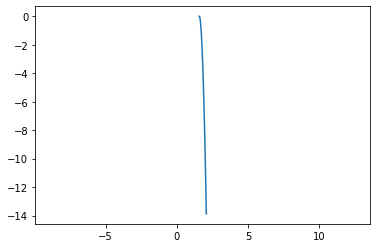

In [125]:
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(straight_trajectory[:,2] , straight_trajectory[:,0])
#plt.plot(straight_trajectory[:,0], straight_trajectory[:,1])
plt.show()

## Demonstrate localization drift in wheel encoders

### Synthetic dataset

In [126]:
all_v = np.ones(100)
all_w = np.zeros(100) 

In [127]:
robot_traj, robot_traj_noisy = [], []
ideal_pose = np.array([0, 0, np.pi/2])
noisy_pose = np.array([0, 0, np.pi/2])

for v, w in zip(all_v, all_w):
    robot_traj.append(ideal_pose)
    robot_traj_noisy.append(noisy_pose)
    #code to update ideal_pose
    ideal_pose = unicycle_model(ideal_pose,v,w)
    
    #code to update noisy pose
    #add gaussian noise with std dev of 0.01 to omega
    noisy_pose = unicycle_model(noisy_pose,v,w+np.random.normal(0,0.01,1))
robot_traj = np.array(robot_traj)
robot_traj_noisy = np.array(robot_traj_noisy)

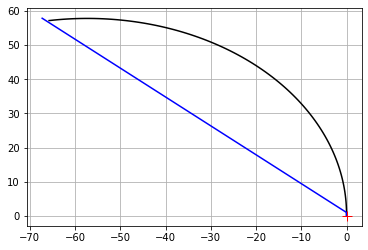

In [128]:
plt.figure()
plt.grid()
#plt.axes().set_aspect("equal","datalim")
plt.plot(robot_traj[:,0], robot_traj[:,1],'k-')
plt.plot(robot_traj_noisy[:,0], robot_traj_noisy[:,1],'b-')
plt.plot(0, 0, 'r+', ms=10)

### Real dataset

In [129]:
!ls

bicycle_model.ipynb  unicycle_model.ipynb  wheel_encoders_and_drift.ipynb
ground_truth.csv     wheel_control.csv


In [130]:
data_dir = "."
ground_truth = pd.read_csv(data_dir + "/ground_truth.csv")
gt_traj = np.array(ground_truth[['x','y']])
wheel_enc = np.array(pd.read_csv(data_dir + "/wheel_control.csv")[['v','w']])

In [131]:
def unicycle_model(pose, v, w, dt = 0.01):
  x, y, theta = pose
  x += v*np.cos(theta)*dt
  y += v*np.sin(theta)*dt
  theta += w*dt
  theta = np.arctan2(np.sin(theta), np.cos(theta))
  return x, y, theta

In [132]:
pose = np.array(ground_truth[['x','y','theta']])[0] #initial pose
robot_traj = []
for v, w in wheel_enc:
    robot_traj.append(pose)
    # code for updating pose
    pose = unicycle_model(pose, v, w)
robot_traj = np.array(robot_traj)

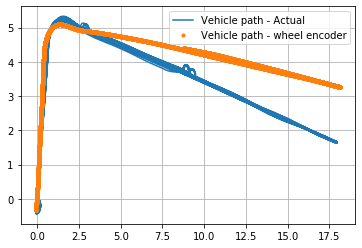

In [133]:
end = 10000
plt.figure()
plt.grid()
plt.plot(gt_traj[:,0], gt_traj[:,1], label='Vehicle path - Actual')
plt.plot(robot_traj[:end,0], robot_traj[:end,1], '.', label='Vehicle path - wheel encoder')
plt.legend()